In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np 
import pandas as pd
import shutil
import os
import cv2
import os
import json

C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Российский набор данных

In [2]:
label_map = pd.read_json('archive\\label_map.json', typ='series')
label_map = label_map.reset_index()
label_map.columns = ['label', 'class']
label_map.head()

,label,class
0,21,1
1,123,2
2,117,3
3,324,4
4,821,5


In [3]:
train_anno = pd.read_json('archive\\train_anno.json', typ='series')
train_anno.head()

images         [{'id': 0, 'width': 1280, 'height': 720, 'file...
annotations    [{'id': 0, 'image_id': 0, 'category_id': 1, 'a...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [4]:
train_anno_reduced = pd.read_json('archive\\train_anno_reduced.json', typ='series')
train_anno_reduced.head()

images         [{'id': 51, 'width': 1280, 'height': 720, 'fil...
annotations    [{'id': 31193, 'image_id': 18983, 'category_id...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [5]:
val_anno = pd.read_json('archive\\val_anno.json', typ='series')
val_anno.head()

images         [{'id': 22978, 'width': 1280, 'height': 720, '...
annotations    [{'id': 37471, 'image_id': 22978, 'category_id...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [6]:
df_images = pd.DataFrame(train_anno.images)
df_annotations = pd.DataFrame(train_anno.annotations)
df_categories = pd.DataFrame(train_anno.categories)

In [7]:
df_images.head()

,id,width,height,file_name
0,0,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,1280,720,rtsd-frames/autosave01_02_2012_09_13_37.jpg


In [8]:
df_annotations.head()

,id,image_id,category_id,area,bbox,iscrowd
0,0,0,1,324,"[649, 376, 18, 18]",0
1,1,1,1,420,"[671, 356, 20, 21]",0
2,2,2,1,702,"[711, 332, 27, 26]",0
3,3,3,1,1332,"[764, 290, 37, 36]",0
4,4,3,2,289,"[684, 384, 17, 17]",0


In [9]:
df_annotations.category_id.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155],
      dtype=int64)

In [10]:
#Кол-во классов
df_annotations.category_id.nunique()

155

In [11]:
df_categories.head()

,id,name
0,1,2_1
1,2,1_23
2,3,1_17
3,4,3_24
4,5,8_2_1


In [12]:
label_mapping = dict(zip(label_map['class'], label_map['label']))
cat_mapping = dict(zip(df_categories['id'], df_categories['name']))

<Axes: ylabel='category_id'>

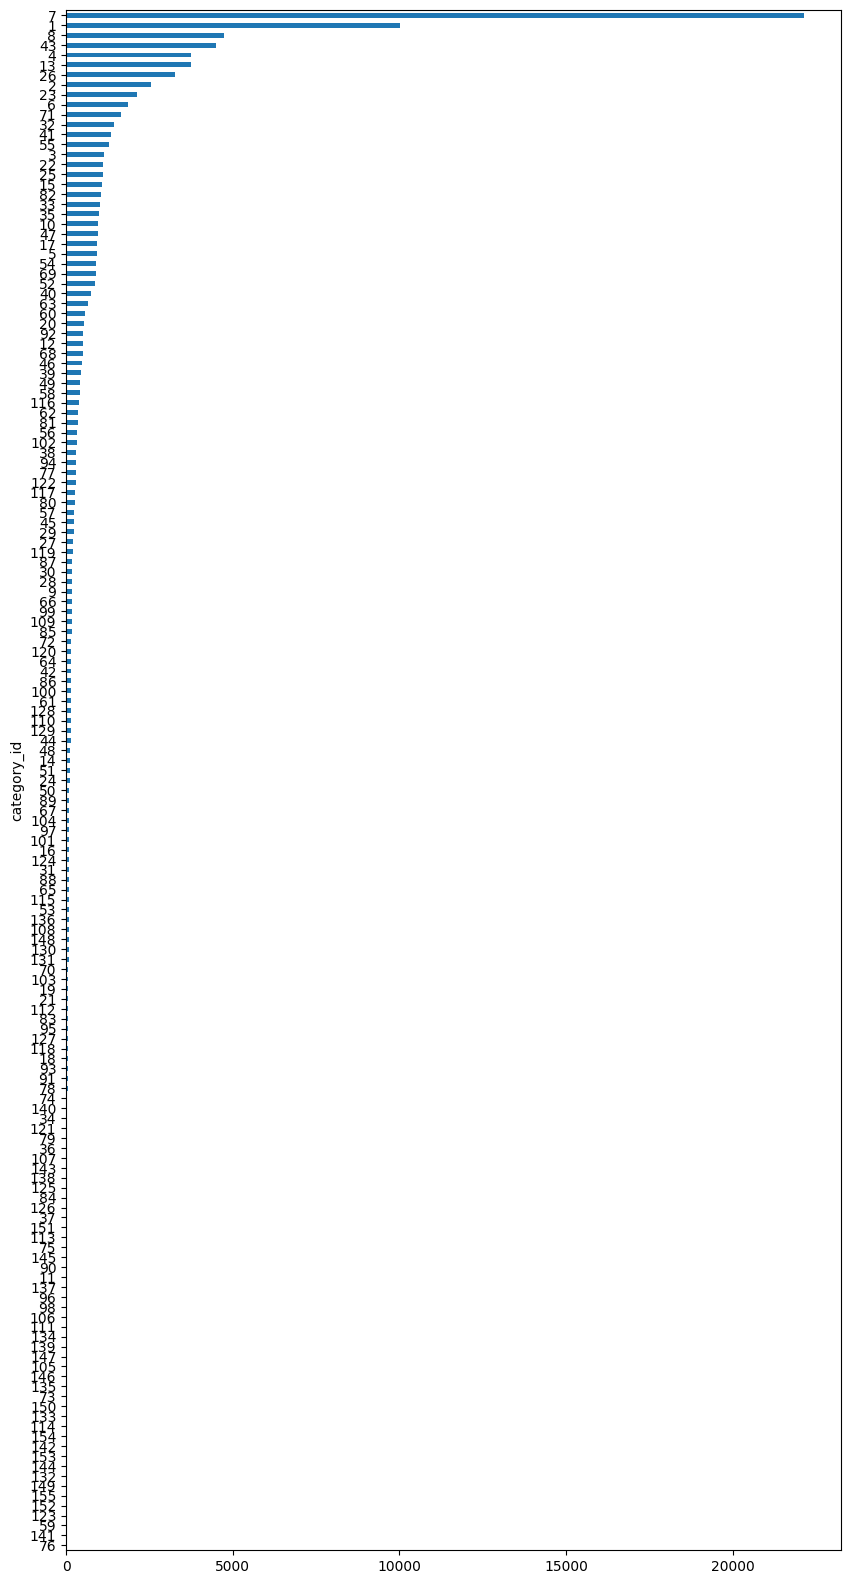

In [13]:
plt.figure(figsize=(10,20))

df_annotations.category_id.value_counts().sort_values().plot(kind = 'barh')

Присутствует дисбаланс классов

In [23]:
def show_image_with_annotations(image_id):
    image_data = df_images[df_images['id'] == image_id].iloc[0]
    annotations = df_annotations[df_annotations['image_id'] == image_id]
    print(annotations)
    image_path = os.path.join("archive/rtsd-frames", image_data['file_name'])
    image = cv2.imread(image_path)

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for _, annotation in annotations.iterrows():
        bbox = annotation['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

      id  image_id  category_id   area                  bbox  iscrowd
179  190       100           18  12644   [1086, 0, 116, 109]        0
180  191       100           19   8514  [1090, 104, 129, 66]        0


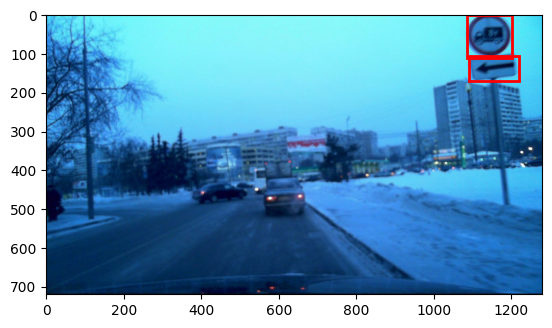

In [26]:
show_image_with_annotations(100)

        id  image_id  category_id  area                bbox  iscrowd
1415  1554      1000            7  3540  [365, 218, 60, 59]        0


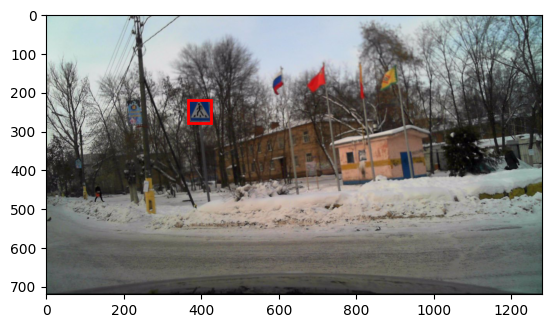

In [28]:
show_image_with_annotations(1000)

### Преобразование в формат YOLO v8

In [61]:
def convert_bbox(bbox, width, height):
    x_center = (bbox[0] + bbox[2] / 2) / width
    y_center = (bbox[1] + bbox[3] / 2) / height
    w = bbox[2] / width
    h = bbox[3] / height
    return x_center, y_center, w, h

In [29]:
images_folder = "rtsd-frames"
output_folder = ["train", "valid", "test"]
output_subfolders = ["images", "labels"]

train_data, test_data = train_test_split(train_anno.images, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [31]:
for data, folder in zip([train_data, valid_data, test_data], output_folder):
    for image_info in tqdm(data):
        
        image_id = image_info["id"]
        file_name = image_info["file_name"].split('/')[-1].split('.')[0]
        annotations = df_annotations[df_annotations.image_id==image_id].to_dict('records')
        labels_path = f'C:/Users/User/Documents/Projects/itmo_deep_learning/archive/{folder}/labels/{file_name}.txt'

        with open(labels_path, "w") as label_file:
            for annotation in annotations:
                cat_id = annotation["category_id"]
                
                cls = cat_id-1
                
                bbox = convert_bbox(annotation["bbox"], image_info["width"], image_info["height"])
                label_file.write(f"{cls} {' '.join(map(str, bbox))}\n")

        image_path_src = r'C:/Users/User/Documents/Projects/itmo_deep_learning/archive/rtsd-frames/rtsd-frames/'+file_name
        image_path_dst = '/'.join(['C:/Users/User/Documents/Projects/itmo_deep_learning/archive', folder, 'images',file_name])
        shutil.copy(image_path_src+'.jpg', image_path_dst+'.jpg')

100%|██████████| 10838/10838 [00:27<00:00, 393.03it/s]


### Создание yaml файла для обучения

In [17]:
import yaml
from transliterate import translit

In [58]:
train_anno = pd.read_json('archive\\train_anno.json', typ='series')
label_map = pd.DataFrame(train_anno.categories)
label_map['id'] = label_map['id'].astype('str')

del train_anno

In [59]:
label_map.head()

,id,name
0,1,2_1
1,2,1_23
2,3,1_17
3,4,3_24
4,5,8_2_1


In [60]:
df_categories.name.nunique()

155

In [61]:
signs = pd.read_excel('signs.xlsx')
signs['Номер знака'] = signs['Номер знака'].apply(lambda value: value.replace('.','_'))
signs.head()

,Номер знака,Название
0,1_1,Железнодорожный переезд со шлагбаумом
1,1_2,Железнодорожный переезд без шлагбаума
2,1_3_1,Однопутная железная дорога
3,1_3_2,Многопутная железная дорога
4,1_4_1,Приближение к железнодорожному переезду


In [62]:
signs.shape

(315, 2)

In [63]:
signs['Номер знака'].nunique()

315

In [69]:
label_map = label_map.merge(signs, left_on='name', right_on='Номер знака', how='left')
label_map.head()

,id,name,Номер знака,Название
0,1,2_1,2_1,Главная дорога
1,2,1_23,1_23,Дети
2,3,1_17,1_17,Искусственная неровность
3,4,3_24,3_24,Ограничение максимальной скорости
4,5,8_2_1,8_2_1,Зона действия


In [70]:
label_map[label_map['Название'].isna()]

,id,name,Номер знака,Название
13,14,8_13_1,NaN,NaN
19,20,3_4_1,NaN,NaN
27,28,4_1_2_1,NaN,NaN
44,45,3_18,NaN,NaN
54,55,5_15_2_2,NaN,NaN
57,58,2_3,NaN,NaN
61,62,1_11,NaN,NaN
64,65,1_20,NaN,NaN
65,66,1_12,NaN,NaN
109,110,4_1_2_2,NaN,NaN


 Непонятно, что это за знаки. Проверка в ручную внесла только еще большей неопределенности.
 Поэтому оставим по этим знакам исходный label

In [72]:
label_map['my_label'] = np.where(label_map['Название'].isna(), label_map.name, label_map['Название'])

In [73]:
label_map.to_excel('signs_desc.xlsx')

Русские символы в yaml не вставляются, поэтому оставляем label

In [80]:
dict_file = [
    {'names': label_map['label'].values.tolist()},
    {'ncc' : [155]},
    {'test' : ['C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\test']},
    {'train' : ['C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\train']},
    {'val' : ['C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\valid']}
]

In [82]:
with open(r'data_ru.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)

### Создаем yaml в ручную 

In [74]:
data = pd.read_excel('signs_desc.xlsx', index_col=0)

In [75]:
data.head()

,id,name,Номер знака,Название,my_label
0,1,2_1,2_1,Главная дорога,Главная дорога
1,2,1_23,1_23,Дети,Дети
2,3,1_17,1_17,Искусственная неровность,Искусственная неровность
3,4,3_24,3_24,Ограничение максимальной скорости,Ограничение максимальной скорости
4,5,8_2_1,8_2_1,Зона действия,Зона действия


In [76]:
data.shape

(155, 5)

In [79]:
for i in data.my_label.values.tolist():
    #trans = translit(i, "ru", reversed=True)
    #print('-',f"'{trans}'")
    print('-',f"{i}")

- Главная дорога
- Дети
- Искусственная неровность
- Ограничение максимальной скорости
- Зона действия
- Искусственная неровность
- Пешеходный переход
- Место остановки автобуса и (или) троллейбуса
- Конец зоны ограничения максимальной скорости
- Стоп-линия
- Зона приёма радиостанции, передающей информацию о дорожном движении
- Конец главной дороги
- Уступите дорогу
- 8_13_1
- Объезд препятствия справа
- Сужение дороги
- Дорожные работы
- Движение грузовых автомобилей запрещено
- Направления действия
- 3_4_1
- Движение направо или налево
- Объезд препятствия справа или слева
- Движение прямо
- Прочие опасности
- Конец полосы
- Остановка запрещена
- Скользкая дорога
- 4_1_2_1
- Место для разворота
- Расстояние до объекта
- Надземный пешеходный переход
- Начало полосы
- Автозаправочная станция
- Опасная обочина
- Парковка (парковочное место)
- Расстояние до объекта
- Платные услуги
- Неровная дорога
- Опасный поворот
- Подземный пешеходный переход
- Направления движения по полосам
- Боль

In [ ]:
- names:
...
nc: 155
test: C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\test
train: C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\train
val: C:\\Users\\User\\Documents\\Projects\\itmo_deep_learning\\archive\\valid